# HBV hydrological model forced with ERA5 forcing data
In this notebook we will demonstrate how to generate forcing data for the HBV hydrological model from the ERA5 dataset using the eWaterCycle platform. It is assumed that you already have seen [this notebook which explains the basics of the HBV model and generating forcing using eWaterCycle](example_model_run_HBV_camels_catchment_camels_forcing.ipynb). This notebooks purely focuses on the differences when generating forcing from ERA5.

Below a few collapsed cells are identical to those from that notebook.

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [3]:
# Load settings
# Read from the JSON file
with open("settings.json", "r") as json_file:
    settings = json.load(json_file)

## Generate or load forcing
when generating forcing using eWaterCycle there are two important choices to make: dataset that the data comes from and type of forcing that the model requires. The dataset in this example is ERA5. The HBV model in eWaterCycle needs potential evaporation data. Both the 'caravan' type forcing as well as the 'LumpedMakkinkForcing' provide potential evaporation. Note that the 'caravan' type forcing only works with the 'caravan' dataset as well, so here we select 'ERA5 for the dataset and LumpedMakkinkForcing for the type.

Note that ERA5 data needs to be stored on the system you are working on. For SURF Research Cloud machines running the eWaterCycle catalog item, this is handled by the eWaterCycle team. 

More complex models often require their own type of forcing, for example the wflow model requires 'wflow' type forcing specifically designed for that model, but this is not the case for HBV in eWaterCycle.

In [4]:
# This additional steo is needed because ERA5 forcing data is stored deep in a sub-directory
load_location = Path(settings['path_ERA5']) / "work" / "diagnostic" / "script" 
ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [5]:
print(ERA5_forcing_object)

LumpedMakkinkForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2010-07-31T00:00:00Z',
    directory=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/ERA5/work/diagnostic/script')
,
    shape=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/ERA5/work/diagnostic/script/hyset
s_01371500.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_1997-2010.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_1997-2010.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1997-2010.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

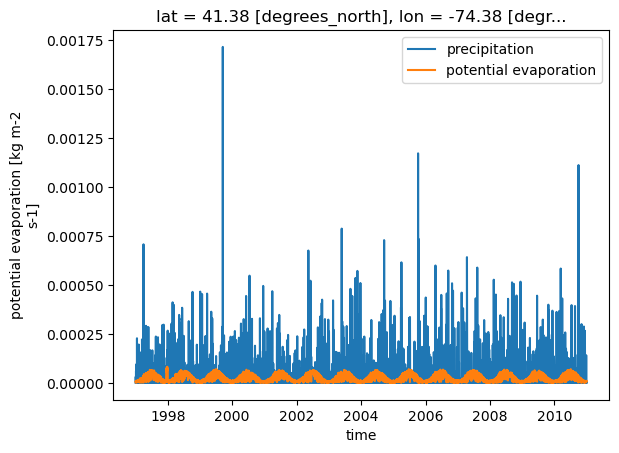

In [6]:
# Quick plot of the precipitation and potential evaporation data
ds_ERA5 = xr.open_mfdataset([ERA5_forcing_object['pr'],ERA5_forcing_object['evspsblpot']])
ds_ERA5["pr"].plot(label = 'precipitation')
ds_ERA5["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()

## CMIP historical forcing

In [7]:
cmip_dataset = {
    "dataset": settings['CMIP_info']['dataset'],
    "project": settings['CMIP_info']['project'],
    "grid": "gn",
    "exp": "historical",
    "ensemble": 'r3i1p1f1',
}

In [8]:
# This is the subfolder for this specific combination of dataset, experiment and ensemblemember
path_CMIP6 = Path(settings['path_CMIP6']) / cmip_dataset["dataset"] / cmip_dataset["exp"] / cmip_dataset["ensemble"]


In [9]:
# This is needed because ERA5 forcing data is stored deep in a sub-directory
load_location = path_CMIP6 / "work" / "diagnostic" / "script" 
CMIP_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [10]:
print(CMIP_forcing_object)

LumpedMakkinkForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2010-07-31T00:00:00Z',
    directory=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/CMIP6/MPI-ESM1-2-HR/historica
l/r3i1p1f1/work/diagnostic/script'),
    shape=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/CMIP6/MPI-ESM1-2-HR/historical/r3
i1p1f1/work/diagnostic/script/hysets_01371500.shp'),
    filenames={
        'pr': 'CMIP6_MPI-ESM1-2-HR_day_historical_r3i1p1f1_pr_gn_1997-2010.nc',
        'tas': 'CMIP6_MPI-ESM1-2-HR_day_historical_r3i1p1f1_tas_gn_1997-2010.nc',
        'rsds': 'CMIP6_MPI-ESM1-2-HR_day_historical_r3i1p1f1_rsds_gn_1997-2010.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

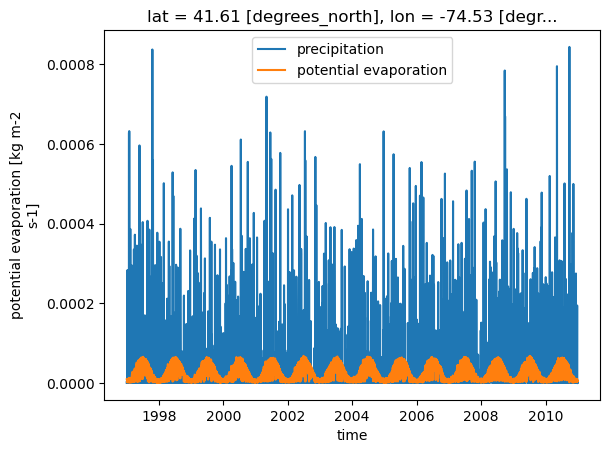

In [11]:
# Quick plot of the precipitation and potential evaporation data
ds_CMIP = xr.open_mfdataset([CMIP_forcing_object['pr'],CMIP_forcing_object['evspsblpot']])
ds_CMIP["pr"].plot(label = 'precipitation')
ds_CMIP["evspsblpot"].plot(label = 'potential evaporation')
plt.legend()

## Run models

From here on down everything is the same as in [this](example_model_run_HBV_camels_catchment_camels_forcing.ipynb) notebook that uses caravan forcing, the only thing that changes is we now point to the ERA5 forcing object.

In [12]:
# Load calibration constants from a csv file
par_0 = np.loadtxt(settings['path_caravan'] + "/" + settings['caravan_id'] + "_params_SCE.csv", delimiter = ",")

In [13]:
# Print parameter names and values
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(par_0, decimals=3))))

[
    ('Imax', 7.572),
    ('Ce', 1.0),
    ('Sumax', 45.908),
    ('Beta', 3.154),
    ('Pmax', 0.009),
    ('Tlag', 1.218),
    ('Kf', 0.1),
    ('Ks', 0.01),
    ('FM', 2.369)
]

In [14]:
# Set initial state values
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [15]:
# Create model object, notice the forcing object.
models = {"ERA5": ewatercycle.models.HBV(forcing=ERA5_forcing_object),
          "CMIP6": ewatercycle.models.HBV(forcing=CMIP_forcing_object)}

In [16]:
model_output=dict()

In [17]:
for modelName, model in models.items():

    # Create config file in model.setup()
    config_file, _ = model.setup(parameters=par_0, initial_storage=s_0)
    # Initialize model
    model.initialize(config_file)
    # Run model, capture calculated discharge and timestamps
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
    # Finalize model (shuts down container, frees memory)
    model.finalize()

    # Make a pandas series
    model_output[modelName] = pd.Series(data=Q_m, name="modelled discharge, forcing: " + modelName, index=time)

## Process results
Finally, we use standard python libraries to visualize the results. We put the model output into a pandas Series to make plotting easier.

In [18]:
caravan_data_object = ewatercycle.forcing.sources['CaravanForcing'].load(directory=settings['path_caravan'])

In [19]:
print(caravan_data_object)

CaravanForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2010-07-31T00:00:00Z',
    directory=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan'),
    shape=PosixPath('/home/rhut/ewatercycleClimateImpact/HBV/data/hysets_01371500/caravan/hysets_01371500.shp'),
    filenames={
        'tasmax': 'hysets_01371500_1997-08-01_2010-07-31_tasmax.nc',
        'tas': 'hysets_01371500_1997-08-01_2010-07-31_tas.nc',
        'Q': 'hysets_01371500_1997-08-01_2010-07-31_Q.nc',
        'evspsblpot': 'hysets_01371500_1997-08-01_2010-07-31_evspsblpot.nc',
        'tasmin': 'hysets_01371500_1997-08-01_2010-07-31_tasmin.nc',
        'pr': 'hysets_01371500_1997-08-01_2010-07-31_pr.nc'
    }
)

In [52]:
# Load the observations from the caravan object
caravan_discharge_observation = xr.open_mfdataset([caravan_data_object['Q']])
caravan_discharge_observation = caravan_discharge_observation.rename_vars({'Q':'observed Q Caravan'})
print(caravan_discharge_observation)

<xarray.Dataset> Size: 57kB
Dimensions:             (time: 4748)
Coordinates: (12/18)
  * time                (time) datetime64[ns] 38kB 1997-08-01 ... 2010-07-31
    basin_id            |S64 64B ...
    timezone            |S64 64B ...
    name                |S64 64B ...
    country             |S64 64B ...
    lat                 float64 8B ...
    ...                  ...
    moisture_index      float64 8B ...
    seasonality         float64 8B ...
    high_prec_freq      float64 8B ...
    high_prec_dur       float64 8B ...
    low_prec_freq       float64 8B ...
    low_prec_dur        float64 8B ...
Data variables:
    observed Q Caravan  (time) float32 19kB dask.array<chunksize=(4748,), meta=np.ndarray>

In [53]:
# We want to also be able to use the output of this model run in different analyses. Therefore, we save it as a NetCDF file.
xr_model_output = xr.merge([model_output_per_model.to_xarray() for name, model_output_per_model in model_output.items()])
xr_model_output = xr_model_output.rename({'index': 'time'})
xr_model_output.attrs['units'] = 'mm/d'
print(xr_model_output)


<xarray.Dataset> Size: 123kB
Dimensions:                             (time: 5112)
Coordinates:
  * time                                (time) datetime64[ns] 41kB 1997-01-02...
Data variables:
    modelled discharge, forcing: ERA5   (time) float64 41kB 0.0502 ... 0.6459
    modelled discharge, forcing: CMIP6  (time) float64 41kB 0.0502 ... 1.565
Attributes:
    units:    mm/d

In [54]:
# Interpolate model data to match the timestamps of the observations
xr_model_output_interp = xr_model_output.interp(time=caravan_discharge_observation.time)

# Merge the interpolated model output with observations
xr_merged = xr.merge([xr_model_output_interp, caravan_discharge_observation[['observed Q Caravan']]])

print(xr_merged)


<xarray.Dataset> Size: 133kB
Dimensions:                             (time: 4748)
Coordinates: (12/18)
  * time                                (time) datetime64[ns] 38kB 1997-08-01...
    basin_id                            |S64 64B b'hysets_01371500'
    timezone                            |S64 64B b'America/New_York'
    name                                |S64 64B b'WALLKILL RIVER AT GARDINER...
    country                             |S64 64B b'United States of America'
    lat                                 float64 8B 41.69
    ...                                  ...
    moisture_index                      float64 8B -0.7513
    seasonality                         float64 8B 0.2494
    high_prec_freq                      float64 8B 0.05647
    high_prec_dur                       float64 8B 1.107
    low_prec_freq                       float64 8B 0.6436
    low_prec_dur                        float64 8B 3.422
Data variables:
    modelled discharge, forcing: ERA5   (time) float64 38kB 0.01768 ... 0.66
    modelled discharge, forcing: CMIP6  (time) float64 38kB 2.495 ... 1.655
    observed Q Caravan                  (time) float32 19kB dask.array<chunksize=(4748,), meta=np.ndarray>
Attributes:
    units:    mm/d

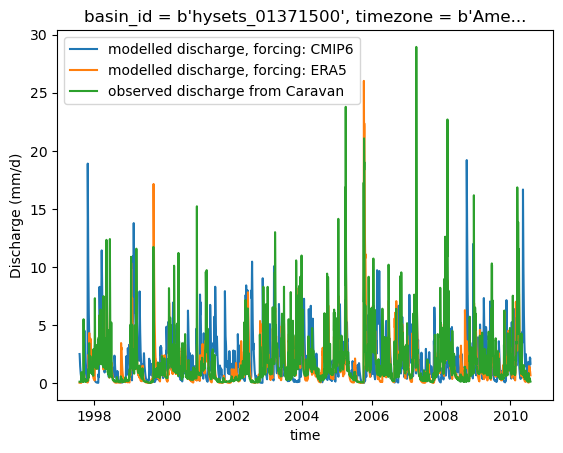

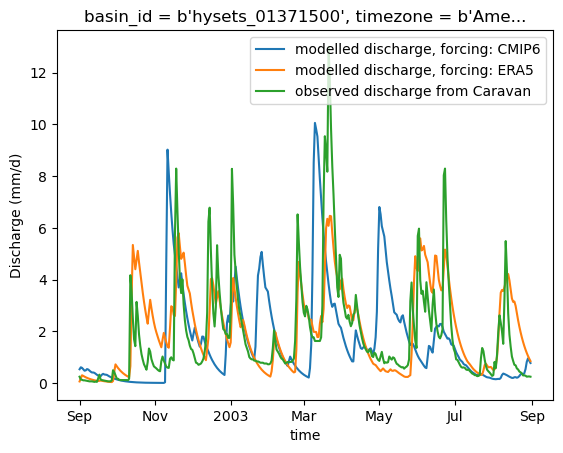

In [55]:
def plot_hydrograph(data_array):
    plt.figure()
    data_array['modelled discharge, forcing: CMIP6'].plot(label = 'modelled discharge, forcing: CMIP6')
    data_array['modelled discharge, forcing: ERA5'].plot(label = 'modelled discharge, forcing: ERA5')
    data_array['observed Q Caravan'].plot(label = 'observed discharge from Caravan')
    plt.ylabel("Discharge (mm/d)")
    plt.legend()


xr_one_year = xr_merged.sel(time=slice('2002-09-01', '2003-08-31'))

plot_hydrograph(xr_merged)
plot_hydrograph(xr_one_year)

In [57]:
# Save the xarray Dataset to a NetCDF file
xr_merged.to_netcdf(Path(settings['base_path']) / (settings['caravan_id'] + '_historic_output.nc'))